### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://qiskit.org/textbook/ch-applications/vqe-molecules.html

In [1]:
import tensorflow as tf

from qiskit import QuantumCircuit, Aer, execute
from math import asin, sqrt, ceil
from qiskit.opflow import Z, CircuitStateFn, StateFn, PauliExpectation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Layer, ReLU

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
tf.executing_eagerly()

True

In [3]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [4]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [5]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

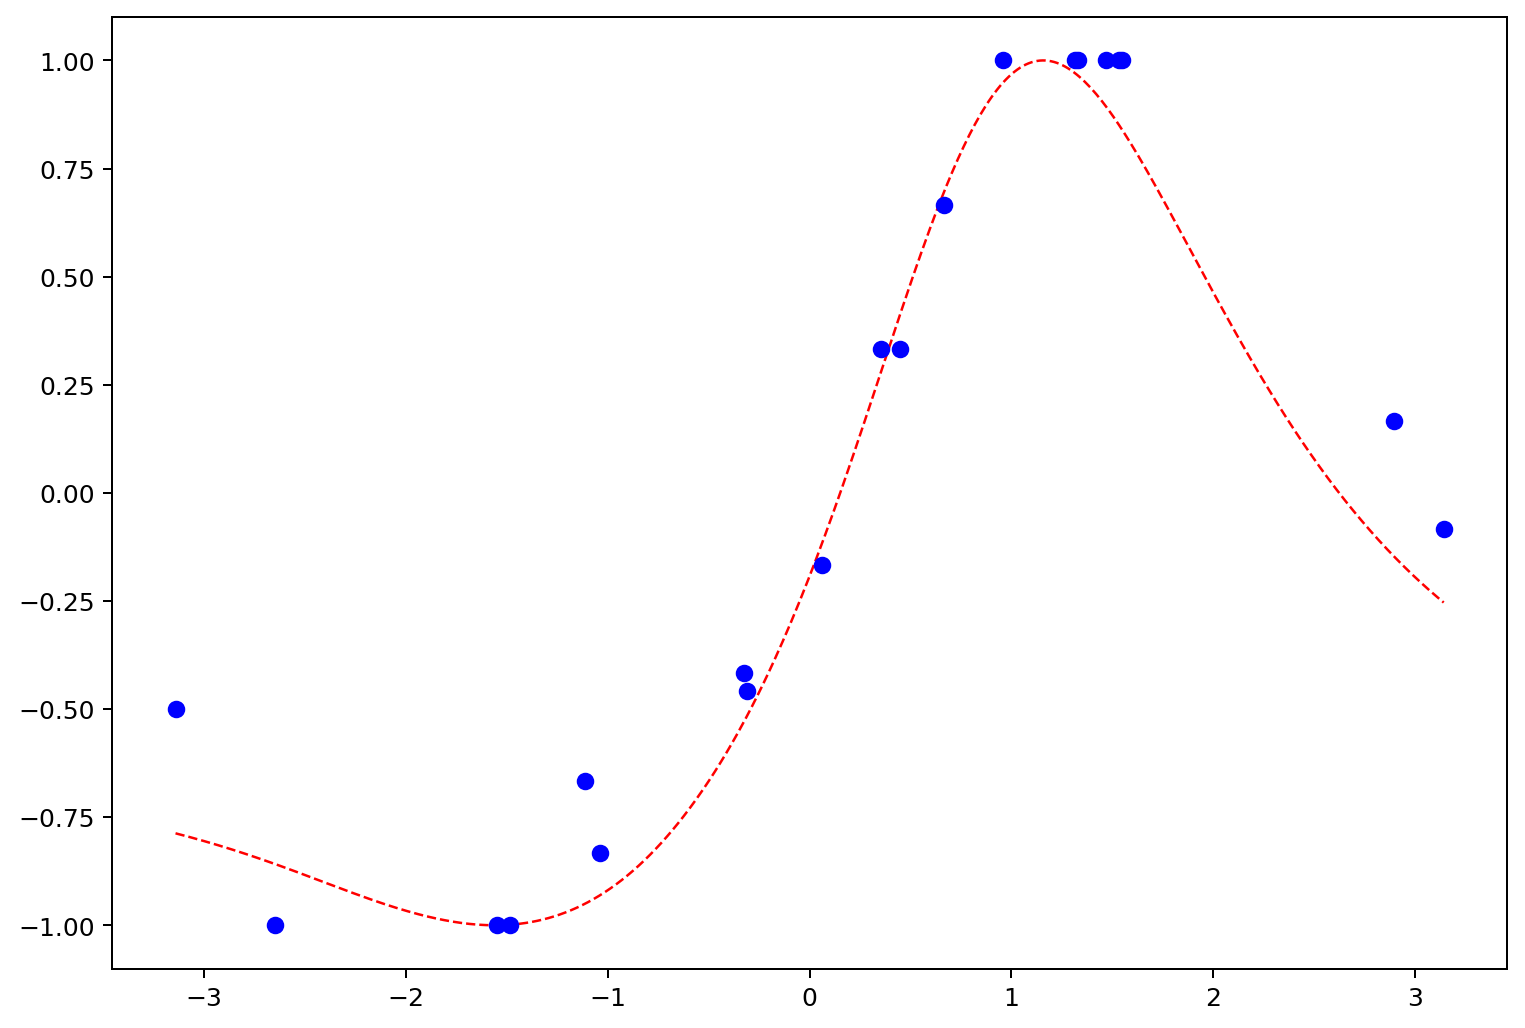

In [6]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

XX = X_[indices].reshape(-1,1)
yy = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

yy = detrend(yy)

#XX = scale(XX, 0, 1)
XX = scale(XX) # from -pi to pi
yy = scale(yy, -1, 1)

#X_ = scale(X_, 0, 1)
X_ = scale(X_) # from -pi to pi
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(XX, yy, "bo", label = 'Points to fit')
plt.show()

In [7]:
def prob_to_angle(prob):
    return 2*asin(sqrt(prob))

In [8]:
def quantum_layer2(initial_parameters, num_qubits):
   
    simulator = Aer.get_backend('qasm_simulator')
    shots = 4096

    expectations = []
    
    for i in range(len(initial_parameters)):
        
        quantumCircuit = QuantumCircuit(num_qubits)

        quantumCircuit.h(range(num_qubits))
    
        angles = initial_parameters[i]
        
        for j in range(len(angles)):
            #quantumCircuit.ry(prob_to_angle(float(angles[j])), j)
            #quantumCircuit.ry(angles[j] * np.pi, j)
            quantumCircuit.ry(angles[j], j)
   
        quantumCircuit.measure_all()

        job = execute(quantumCircuit, backend=simulator, shots=shots)
        result = job.result().get_counts(quantumCircuit)

        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / shots
        
        # Get state expectation
        expectation_value = np.sum(states * probabilities)
        
        expectations.append(expectation_value)

    diff = num_qubits - len(expectations)
    
    if diff > 0:
        for _ in range(diff):
            expectations.append(0)
            
    return np.array(expectations)

In [9]:
def quantum_layer(initial_parameters, num_qubits):

    expectations = []
    
    for i in range(len(initial_parameters)):
        
        quantumCircuit = QuantumCircuit(num_qubits)

        quantumCircuit.h(range(num_qubits))
    
        angles = initial_parameters[i]
        
        for j in range(len(angles)):
            #quantumCircuit.ry(prob_to_angle(float(angles[j])), j)
            #quantumCircuit.ry(angles[j] * np.pi, j)
            quantumCircuit.ry(angles[j], j)

        #quantumCircuit.h(range(num_qubits))
 
        operator = Z
        for _ in range(num_qubits - 1):
            operator @= Z
          
        psi = StateFn(quantumCircuit)
        #psi = CircuitStateFn(quantumCircuit)
        #expectation_value = psi.adjoint().compose(operator).compose(psi).eval() 
        expectation_value = (~psi @ operator @ psi).eval()
        #expectation_value = PauliExpectation().convert(expectation_value).eval()

        expectations.append(expectation_value)
 
    diff = num_qubits - len(expectations)
    
    if diff > 0:
        for _ in range(diff):
            expectations.append(0j)
    
    return expectations

In [10]:
class Linear(Layer):
    
    def __init__(self, output_size, batch_size = 10, units = 1, input_dim=1, num_qubits = 1, **kwargs):
        
        super(Linear, self).__init__(**kwargs)
        
        #self.threshold = 0.1
        self.num_qubits = num_qubits
        self.output_size = output_size
        self.dense = tf.keras.layers.Dense(num_qubits, name='internal_dense')
        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def build(self, input_shape): 
        self.input_size = input_shape[1]        
        self.w = self.add_weight(shape=(self.input_size, self.output_size), initializer='random_normal', trainable=True)
        super(Linear, self).build(input_shape)
        
    def get_config(self):
        config = super(Linear, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape_a, shape_b = input_shape
        return [shape_a, shape_b]
    
    def call(self, inputs):
        
        if (tf.executing_eagerly()):
            
            final_output = []
        
            for i in range(inputs.shape[0]):
                pred = quantum_layer(inputs.numpy(), self.num_qubits)
                final_output.append(list(pred))
            
            out_layer = tf.keras.layers.Dense(self.num_qubits, activation='relu')
            
            return tf.convert_to_tensor(final_output)
        
        #return tf.sigmoid(tf.add(tf.matmul(inputs, self.w**2), self.b))
        #x = self.dense(inputs)
        return inputs

In [11]:
n_qubits = 1

In [12]:
def sequential_model():

    layers_arr = []
    layers_arr.append(Dense(n_qubits, activation = 'linear', input_shape = [1], name = "dense1"))
    layers_arr.append(Linear(output_size = n_qubits, units = 1, input_dim = n_qubits, num_qubits = n_qubits, name = "quantum1"))
    #layers_arr.append(Dense(1, activation="linear", name = "dense2"))   
    layers_arr.append(Dense(1, name ="dense3"))

    return Sequential(layers_arr)

In [13]:
model = sequential_model()

#optimizer = Adam(learning_rate=0.01)
optimizer = SGD(learning_rate=0.01)

#model.compile(loss='mse', optimizer = optimizer, metrics = ['mae', 'mse', 'acc'], run_eagerly=True)
model.compile(optimizer, loss='mse', metrics=["accuracy"], run_eagerly=True)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 1)                 2         
_________________________________________________________________
quantum1 (Linear)            (None, 1)                 4         
_________________________________________________________________
dense3 (Dense)               (None, 1)                 2         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(XX, yy, epochs=500, batch_size=n_qubits, validation_split = 0.25)

#history = model.fit(XX, yy, epochs = 50, batch_size=n_qubits, validation_split = 0.25)

Epoch 1/500
15/15 [==============================] - 0s 27ms/step - loss: 0.0930 - accuracy: 0.2000 - val_loss: 0.0684 - val_accuracy: 0.6000
Epoch 2/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0748 - accuracy: 0.2000 - val_loss: 0.0575 - val_accuracy: 0.6000
Epoch 3/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0293 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0616 - accuracy: 0.2000 - val_loss: 0.0488 - val_accuracy: 0.6000
Epoch 4/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0519 - accuracy: 0.2000 - val_loss: 0.0422 - val_accuracy: 0.6000
Epoch 5/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0702 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0450 - accuracy: 0.2000 - val_loss: 0.0371 - val_accuracy: 0.6000
Epoch 6/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0398 - accuracy: 0.2000 - val_loss: 0.0334 - val_accuracy: 0.6000
Epoch 7/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0524 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0359 - accuracy: 0.2000 - val_loss: 0.0308 - val_accuracy: 0.6000
Epoch 8/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0329 - accuracy: 0.2000 - val_loss: 0.0290 - val_accuracy: 0.6000
Epoch 9/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0241 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0307 - accuracy: 0.2000 - val_loss: 0.0277 - val_accuracy: 0.6000
Epoch 10/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0290 - accuracy: 0.2000 - val_loss: 0.0270 - val_accuracy: 0.6000
Epoch 11/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0340 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0277 - accuracy: 0.2000 - val_loss: 0.0267 - val_accuracy: 0.6000
Epoch 12/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0267 - accuracy: 0.2000 - val_loss: 0.0265 - val_accuracy: 0.6000
Epoch 13/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0260 - accuracy: 0.2000 - val_loss: 0.0268 - val_accuracy: 0.6000
Epoch 14/500


15/15 [==============================] - 0s 15ms/step - loss: 0.0254 - accuracy: 0.2000 - val_loss: 0.0273 - val_accuracy: 0.6000
Epoch 15/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0250 - accuracy: 0.2000 - val_loss: 0.0277 - val_accuracy: 0.6000
Epoch 16/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0247 - accuracy: 0.2000 - val_loss: 0.0278 - val_accuracy: 0.6000
Epoch 17/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0245 - accuracy: 0.2000 - val_loss: 0.0282 - val_accuracy: 0.6000
Epoch 18/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0203 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0243 - accuracy: 0.2000 - val_loss: 0.0285 - val_accuracy: 0.6000
Epoch 19/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0241 - accuracy: 0.2000 - val_loss: 0.0285 - val_accuracy: 0.6000
Epoch 20/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0262 - accuracy: 0.1667WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0240 - accuracy: 0.2000 - val_loss: 0.0286 - val_accuracy: 0.6000
Epoch 21/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0240 - accuracy: 0.2000 - val_loss: 0.0293 - val_accuracy: 0.6000
Epoch 22/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0134 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 20ms/step - loss: 0.0239 - accuracy: 0.2000 - val_loss: 0.0300 - val_accuracy: 0.6000
Epoch 23/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0239 - accuracy: 0.2000 - val_loss: 0.0298 - val_accuracy: 0.6000
Epoch 24/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0239 - accuracy: 0.2000 - val_loss: 0.0298 - val_accuracy: 0.6000


Epoch 25/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0304 - val_accuracy: 0.6000
Epoch 26/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0305 - val_accuracy: 0.6000
Epoch 27/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0306 - val_accuracy: 0.6000
Epoch 28/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0304 - val_accuracy: 0.6000
Epoch 29/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0034 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0309 - val_accuracy: 0.6000
Epoch 30/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0307 - val_accuracy: 0.6000
Epoch 31/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0042 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0307 - val_accuracy: 0.6000
Epoch 32/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 33/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0279 - accuracy: 0.2727WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 34/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 35/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0205 - accuracy: 0.2308WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 36/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 37/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 38/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0040 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 39/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 40/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0376 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 41/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 42/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0133 - accuracy: 0.2000        WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 43/500
15/15 [==============================] - 0s 19ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 44/500
 7/15 [=============>................] - ETA: 0s - loss: 0.0219 - accuracy: 0.2857WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 45/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 46/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0194 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 47/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 48/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0277 - accuracy: 0.1818    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 49/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 50/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 51/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0409 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 52/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 53/500
 1/15 [=>............................] - ETA: 0s - loss: 4.7912e-04 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0323 - val_accuracy: 0.6000
Epoch 54/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 55/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0293 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 15ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 56/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 57/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0218 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 58/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 59/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0147 - accuracy: 0.1818    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 60/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 61/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 62/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 63/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 64/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0414 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 65/500
15/15 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.20 - 0s 19ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 66/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0194 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 67/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 68/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0252 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0324 - val_accuracy: 0.6000
Epoch 69/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0326 - val_accuracy: 0.6000
Epoch 70/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0196 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0330 - val_accuracy: 0.6000
Epoch 71/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0327 - val_accuracy: 0.6000
Epoch 72/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0326 - val_accuracy: 0.6000


Epoch 73/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 74/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 75/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0039 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 76/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 77/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0863 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 78/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 79/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0187 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 80/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 81/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0194 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 82/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 83/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0196 - accuracy: 0.2727    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 84/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 85/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 86/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 87/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 88/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0037 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 89/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 90/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0040 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 91/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 92/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0318 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 93/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 94/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0249 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 95/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 96/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0310 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 97/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 98/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 99/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0072 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 100/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 101/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0787 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 102/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 103/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0382 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 104/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 105/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0202 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0323 - val_accuracy: 0.6000
Epoch 106/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 107/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0271 - accuracy: 0.1000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 108/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 109/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0197 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 110/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 111/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 112/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 113/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 114/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0421 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 115/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 116/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0218 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 117/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 118/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0115 - accuracy: 0.4000        WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 119/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0310 - val_accuracy: 0.6000
Epoch 120/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0157 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 121/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 122/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 123/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 124/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 125/500
 1/15 [=>............................] - ETA: 0s - loss: 5.3227e-04 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 126/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 127/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0203 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 128/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 129/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0112 - accuracy: 0.4000        WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 130/500
15/15 [==============================] - 0s 22ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 131/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0222 - accuracy: 0.2727    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 132/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 133/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0248 - accuracy: 0.2143WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 134/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 135/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0310 - val_accuracy: 0.6000
Epoch 136/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0425 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 137/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 138/500
 1/15 [=>............................] - ETA: 0s - loss: 5.4562e-04 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 139/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 140/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0178 - accuracy: 0.1667        WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 141/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 142/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0260 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 143/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 144/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0141 - accuracy: 0.3000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 145/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 146/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 147/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 148/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 149/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0080 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 150/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 151/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0243 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0323 - val_accuracy: 0.6000
Epoch 152/500
15/15 [==============================] - 0s 19ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 153/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0184 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 154/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 155/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0293 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 156/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 157/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 158/500


15/15 [==============================] - 0s 22ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 159/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 160/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0040 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 161/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 162/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0138 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 163/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 164/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0064 - accuracy: 0.1667        WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 165/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 166/500
 9/15 [=================>............] - ETA: 0s - loss: 0.0324 - accuracy: 0.1111    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 167/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 168/500
 9/15 [=================>............] - ETA: 0s - loss: 0.0327 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 169/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 170/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0271 - accuracy: 0.1538    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 171/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 172/500
15/15 [==============================] - 0s 22ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 173/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 174/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 175/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0411 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 176/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 177/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0385 - accuracy: 0.3333    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 178/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 179/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0375 - accuracy: 0.1667WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 180/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 181/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0299 - accuracy: 0.1818    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 182/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 183/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 184/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 185/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 186/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0099 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 187/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 188/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0142 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0324 - val_accuracy: 0.6000
Epoch 189/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 190/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0138 - accuracy: 0.3333    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 191/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 192/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0258 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 193/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 194/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0298 - accuracy: 0.2727WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 195/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 196/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 197/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0086 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 198/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 199/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0102 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 200/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 201/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0108 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.20 - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 202/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 203/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0390 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 204/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 205/500
 9/15 [=================>............] - ETA: 0s - loss: 0.0314 - accuracy: 0.3333WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 19ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 206/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 207/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0203 - accuracy: 0.3000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 208/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 209/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0263 - accuracy: 0.0909    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 210/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 211/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 212/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0857 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 213/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 214/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0071 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 19ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 215/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 216/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0287 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 217/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 218/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0199 - accuracy: 0.3333    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 219/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 220/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0165 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 221/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 222/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 223/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 224/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 225/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0039 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 226/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 227/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0306 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 228/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 229/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0240 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 230/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 231/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0280 - accuracy: 0.3000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 232/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 233/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0249 - accuracy: 0.2143WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 234/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 235/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 236/500


15/15 [==============================] - 0s 22ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 237/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 238/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0101 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 239/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 240/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0845 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 241/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 242/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0203 - accuracy: 0.0000e+00    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 243/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 244/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0388 - accuracy: 0.3333    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 245/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 246/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0215 - accuracy: 0.1000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 247/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 248/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 249/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 250/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 251/500
 1/15 [=>............................] - ETA: 0s - loss: 9.2205e-04 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 252/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 253/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0044 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 254/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 255/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0223 - accuracy: 0.3333    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 256/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 257/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0296 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 19ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 258/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 259/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000


Epoch 260/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 261/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 262/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0069 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 263/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 264/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0265 - accuracy: 0.6000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0310 - val_accuracy: 0.6000
Epoch 265/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 266/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0310 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 15ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 267/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 268/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0233 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 269/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 270/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0246 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 271/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 272/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 273/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0363 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 274/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 275/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0041 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 276/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 277/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0276 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 278/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 279/500
 9/15 [=================>............] - ETA: 0s - loss: 0.0304 - accuracy: 0.3333WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 280/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 281/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0276 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 282/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 283/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 284/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 285/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 286/500
 1/15 [=>............................] - ETA: 0s - loss: 8.4474e-04 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 287/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 288/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0167 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 289/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 290/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0435 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 291/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 292/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0277 - accuracy: 0.3000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 293/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 294/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 295/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 296/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 297/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0069 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 298/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 299/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0127 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 300/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 301/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0069 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 302/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 303/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0175 - accuracy: 0.3000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 304/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 305/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0264 - accuracy: 0.0909    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 306/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 307/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 308/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 309/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 310/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0415 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 15ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 311/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 312/500
 1/15 [=>............................] - ETA: 0s - loss: 5.8873e-04 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 313/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 314/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0244 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 315/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 316/500
 7/15 [=============>................] - ETA: 0s - loss: 0.0262 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 23ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 317/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 318/500
 9/15 [=================>............] - ETA: 0s - loss: 0.0126 - accuracy: 0.2222WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 319/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0324 - val_accuracy: 0.6000
Epoch 320/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0295 - accuracy: 0.1000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0324 - val_accuracy: 0.6000
Epoch 321/500
15/15 [==============================] - 0s 23ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 322/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 323/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 324/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 325/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0840 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 326/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 327/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0040 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 328/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 329/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0125 - accuracy: 0.2000        WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 330/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 331/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0380 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 332/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 333/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0205 - accuracy: 0.1000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 334/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 335/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0228 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 336/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 337/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 338/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0039 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 339/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 340/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0365 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 341/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 342/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0182 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 343/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 344/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0191 - accuracy: 0.4000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 345/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 346/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0189 - accuracy: 0.2727WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 347/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 348/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 349/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 350/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 351/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0035 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 352/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 353/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0233 - accuracy: 0.3333WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0309 - val_accuracy: 0.6000
Epoch 354/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0310 - val_accuracy: 0.6000
Epoch 355/500
 9/15 [=================>............] - ETA: 0s - loss: 0.0271 - accuracy: 0.2222WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0311 - val_accuracy: 0.6000
Epoch 356/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0310 - val_accuracy: 0.6000
Epoch 357/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0264 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 358/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 359/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 360/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 361/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 362/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0070 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 363/500
15/15 [==============================] - 0s 19ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 364/500
 4/15 [=======>......................] - ETA: 0s - loss: 0.0552 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 19ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 365/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 366/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0276 - accuracy: 0.4000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 367/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 368/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0102 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 369/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 370/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0200 - accuracy: 0.3000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 371/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 372/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000


Epoch 373/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 374/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 375/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0368 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 376/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0324 - val_accuracy: 0.6000
Epoch 377/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0497 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.20 - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0326 - val_accuracy: 0.6000
Epoch 378/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0323 - val_accuracy: 0.6000
Epoch 379/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0339 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 380/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 381/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0181 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 382/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 383/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0198 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 384/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 385/500
15/15 [==============================] - 0s 19ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 386/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 387/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 388/500
 1/15 [=>............................] - ETA: 0s - loss: 4.9455e-04 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 389/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 390/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0040 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.20 - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 391/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 392/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0379 - accuracy: 0.1667WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 393/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 394/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0124 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 395/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 396/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0210 - accuracy: 0.3000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 397/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 398/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0252 - accuracy: 0.2143WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 399/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 400/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 401/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0358 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 402/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 403/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0477 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 404/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 405/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0133 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 406/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 407/500
 9/15 [=================>............] - ETA: 0s - loss: 0.0273 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 408/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 409/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0195 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 410/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 411/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000


Epoch 412/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 413/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 414/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0071 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0310 - val_accuracy: 0.6000
Epoch 415/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 416/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0483 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 417/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 418/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0203 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 419/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 420/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0176 - accuracy: 0.1000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 421/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0324 - val_accuracy: 0.6000
Epoch 422/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0211 - accuracy: 0.3000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 423/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 424/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 425/500


15/15 [==============================] - 0s 18ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0323 - val_accuracy: 0.6000
Epoch 426/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 427/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0040 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 20ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 428/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 429/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0070 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0310 - val_accuracy: 0.6000
Epoch 430/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 431/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0313 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 19ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0314 - val_accuracy: 0.6000
Epoch 432/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 433/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0336 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 434/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 435/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0297 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 436/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 437/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0254 - accuracy: 0.1429    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 438/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 439/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 440/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0138 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 441/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 442/500
 1/15 [=>............................] - ETA: 0s - loss: 8.3572e-04 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 443/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 444/500
 5/15 [=========>....................] - ETA: 0s - loss: 0.0315 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 445/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 446/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0156 - accuracy: 0.3333    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 447/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 448/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0147 - accuracy: 0.1818WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 21ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 449/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 450/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0252 - accuracy: 0.1000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 451/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 452/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 453/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0041 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 454/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 455/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0780 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 15ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0313 - val_accuracy: 0.6000
Epoch 456/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 457/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0234 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 458/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 459/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0390 - accuracy: 0.0000e+00    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 460/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 461/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0257 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 462/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 463/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 464/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0322 - val_accuracy: 0.6000
Epoch 465/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 466/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0066 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 467/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0323 - val_accuracy: 0.6000
Epoch 468/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0496 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 469/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 470/500
 7/15 [=============>................] - ETA: 0s - loss: 0.0325 - accuracy: 0.2857WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 19ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 471/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 472/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0284 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 473/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 474/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0284 - accuracy: 0.1000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 475/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 476/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 477/500


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 478/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0312 - val_accuracy: 0.6000
Epoch 479/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0038 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 22ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 480/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 481/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0085 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 482/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 483/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0299 - accuracy: 0.3333    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 484/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 485/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0195 - accuracy: 0.2000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 486/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 487/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0155 - accuracy: 0.3000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 488/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 489/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 490/500
 1/15 [=>............................] - ETA: 0s - loss: 0.0068 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0316 - val_accuracy: 0.6000
Epoch 491/500
15/15 [==============================] - 0s 22ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 492/500
 1/15 [=>............................] - ETA: 0s - loss: 6.5454e-04 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0315 - val_accuracy: 0.6000
Epoch 493/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0317 - val_accuracy: 0.6000
Epoch 494/500
 6/15 [===========>..................] - ETA: 0s - loss: 0.0240 - accuracy: 0.1667    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0321 - val_accuracy: 0.6000
Epoch 495/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0319 - val_accuracy: 0.6000
Epoch 496/500
 9/15 [=================>............] - ETA: 0s - loss: 0.0186 - accuracy: 0.3333WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 497/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0318 - val_accuracy: 0.6000
Epoch 498/500
10/15 [===================>..........] - ETA: 0s - loss: 0.0323 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000
Epoch 499/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 0.2000 - val_loss: 0.0323 - val_accuracy: 0.6000
Epoch 500/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0228 - accuracy: 0.2727WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0', 'quantum1/internal_dense/kernel:0', 'quantum1/internal_dense/bias:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.2000 - val_loss: 0.0320 - val_accuracy: 0.6000


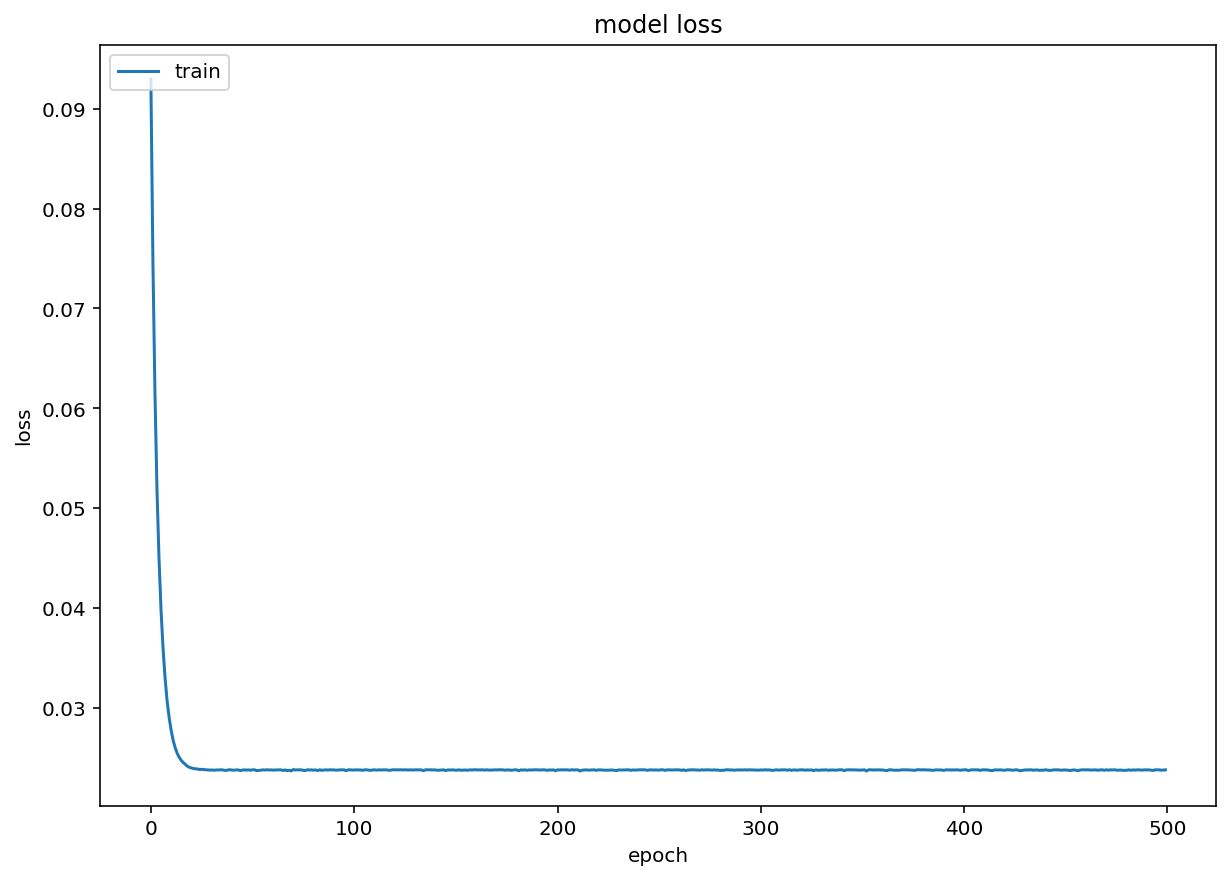

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [17]:
def split_batch_predict(data, num_qubits, model):
    
    splitted_X = None

    if num_qubits > 1:
        num_sections = ceil(X_.shape[0] / num_qubits)
        splitted_X = np.array_split(data.flatten(), num_sections)
    else:
        splitted_X = data

    y_prediction = []

    for arr in splitted_X:
        pred = model.predict(arr)
        y_prediction.append(pred.tolist())
    
    return np.array(y_prediction)

In [18]:
y_predict = split_batch_predict(X_, n_qubits, model)

In [19]:
y_predict_smooth = smooth(y_predict)

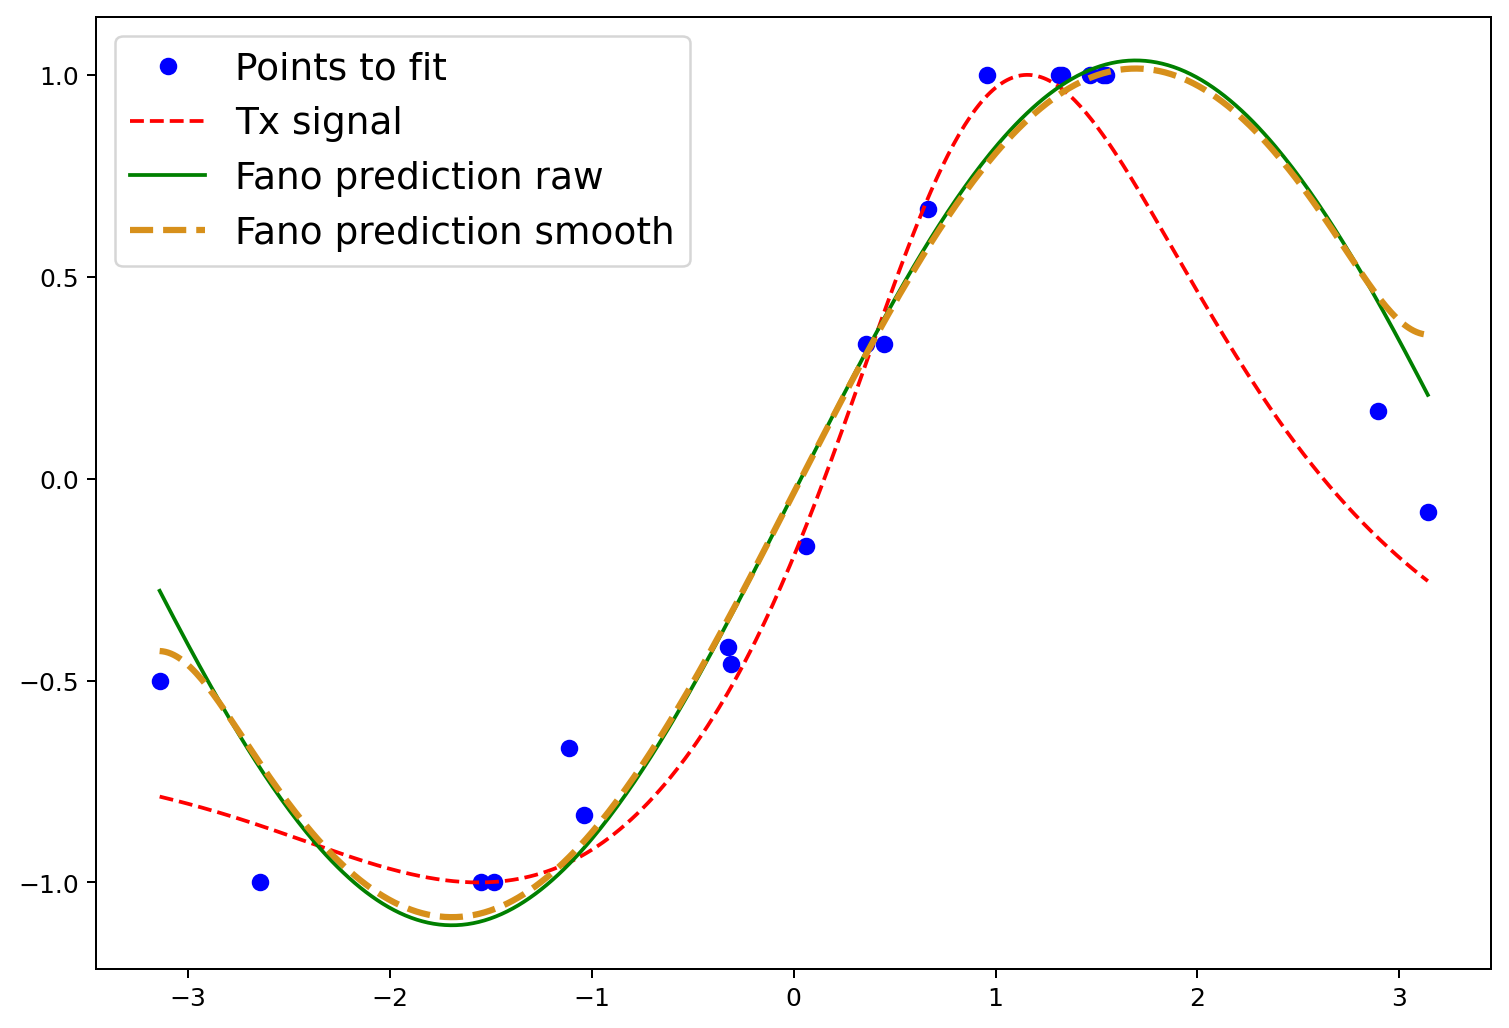

In [20]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(XX, yy, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict.flatten(), "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth.flatten(), "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [21]:
print("Score: %.10f" % r2_score(y_, y_predict.flatten()))

Score: 0.8071524451


In [22]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright